<a href="https://colab.research.google.com/github/ysugiyama3/google_colab/blob/master/cataloging_copy_lookup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Cataloging copy lookup program**

by Yukari Sugiyama (View source code on <a href='https://github.com/ysugiyama3/google_colab'>Github</a>)

---
#### **About the program**
Using Python 3 and OCLC WorldCat Search API, this program automates the work of cataloing copy search. It automatically searches WorldCat for good cataloging copy by LCCN, ISBN, and OCLC numbers. The process considers OCLC records with English cataloging language, encoding levels (blank, 1, 4, I, M) and LC Subject Headings (except for fiction) as good cataloging copy.

#### **What you need**


*   Your own OCLC <a href='https://www.oclc.org/developer/develop/authentication/how-to-request-a-wskey.en.html'>WorldCat Search API key.</a>
*   Excel spreadsheet in which **the 1st, 2nd, 3rd columns must be assigned for LCCN, ISBN, and OCLC number respectively.** The spreadsheet can have as many columns as necesary and must have column headers.

#### **How to run the program**
Execute each step by simply clicking the play button (watch a video demo <a href='https://youtu.be/qAaI75ZTPoA'>here</a>)

---

In [ ]:
#@title 1. Enter your OCLC WorldCat Search API key

from google.colab import files
import pandas as pd
import requests
import xml.etree.ElementTree as ET
from IPython.display import HTML, display
import time
import re
from getpass import getpass

def progress(value, max=50000):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 40%'
        >
            {value}
        </progress>
        <br>{value}/{max}</br>
    """.format(value=value, max=max))

def eng_lang(record):
    cat_lang = record.find('{http://www.loc.gov/MARC21/slim}datafield[@tag="040"]/{http://www.loc.gov/MARC21/slim}subfield[@code="b"]')
    if cat_lang is not None:
        cat_lang = cat_lang.text
        if cat_lang == 'eng':
            return True
    return False

def encoding_level(record):
    elvl = record.find('{http://www.loc.gov/MARC21/slim}leader').text[17:18]
    if elvl in [' ','1','4','I','M']:
        return str(elvl)
    else:
        return ''

def oclc_no(record):
    oclc_no = record.find('{http://www.loc.gov/MARC21/slim}controlfield[@tag="001"]').text
    return oclc_no

def call_no(record):
    call_sub_a = record.find('{http://www.loc.gov/MARC21/slim}datafield[@tag="050"]/{http://www.loc.gov/MARC21/slim}subfield[@code="a"]')
    call_sub_b = record.find('{http://www.loc.gov/MARC21/slim}datafield[@tag="050"]/{http://www.loc.gov/MARC21/slim}subfield[@code="b"]')
    if call_sub_a is not None:
        call_sub_a = call_sub_a.text
    else:
        call_sub_a = ''
    if call_sub_b is not None:
        call_sub_b = ' ' + call_sub_b.text
    else:
        call_sub_b = ''
    call = call_sub_a + call_sub_b
    return call

def fiction(record):
    litf = record.find('{http://www.loc.gov/MARC21/slim}controlfield[@tag="008"]').text[33:34]
    if litf == '0':
        return False
    else:
        return True

def subject(record):
    if fiction(record):
        return 'Yes (Fiction)'
    else:
        subj_count = 0
        person = record.find('{http://www.loc.gov/MARC21/slim}datafield[@ind2="0"][@tag="600"]/{http://www.loc.gov/MARC21/slim}subfield[@code="a"]')
        corp = record.find('{http://www.loc.gov/MARC21/slim}datafield[@ind2="0"][@tag="610"]/{http://www.loc.gov/MARC21/slim}subfield[@code="a"]')
        conf = record.find('{http://www.loc.gov/MARC21/slim}datafield[@ind2="0"][@tag="611"]/{http://www.loc.gov/MARC21/slim}subfield[@code="a"]')
        ti = record.find('{http://www.loc.gov/MARC21/slim}datafield[@ind2="0"][@tag="630"]/{http://www.loc.gov/MARC21/slim}subfield[@code="a"]')
        topic = record.find('{http://www.loc.gov/MARC21/slim}datafield[@ind2="0"][@tag="650"]/{http://www.loc.gov/MARC21/slim}subfield[@code="a"]')
        geo = record.find('{http://www.loc.gov/MARC21/slim}datafield[@ind2="0"][@tag="651"]/{http://www.loc.gov/MARC21/slim}subfield[@code="a"]')

        if person is not None:
            subj_count += 1
        if corp is not None:
            subj_count += 1
        if conf is not None:
            subj_count += 1
        if ti is not None:
            subj_count += 1
        if topic is not None:
            subj_count += 1
        if geo is not None:
            subj_count += 1

        if subj_count > 0:
            return 'Yes'
        else:
            return 'No'

def search_by_lccn(lccn):
    global output_df, hascopy

    time.sleep(0.02)
    url = 'http://www.worldcat.org/webservices/catalog/search/sru?query=srw.dn=%22' + str(lccn) + '%22&servicelevel=full&frbrGrouping=off&maximumRecords=1&wskey=' + wskey
    r = requests.get(url)
    marcxml = r.text
    root = ET.fromstring(marcxml)
    result = root.find('{http://www.loc.gov/zing/srw/}numberOfRecords').text
    if int(result) > 0:
        record = root.find('{http://www.loc.gov/zing/srw/}records/{http://www.loc.gov/zing/srw/}record/{http://www.loc.gov/zing/srw/}recordData/{http://www.loc.gov/MARC21/slim}record')
        oclc = oclc_no(record)
        subj = subject(record)
        call = call_no(record)
        elvl = encoding_level(record)

        if eng_lang(record) and len(elvl) > 0 and subj.startswith('Yes'):
            hascopy += 1
            output_df.loc[index, 'MATCH_OCLC_NO'] = oclc
            output_df.loc[index, 'SUBJECT'] = subj
            output_df.loc[index, 'LC_CALL_NUMBER'] = call
            output_df.loc[index, 'ELVL'] = elvl 
            return True
    return False


def search_dlc_by_isbn(isbn):
    global output_df, hascopy

    time.sleep(0.02)
    url = 'http://www.worldcat.org/webservices/catalog/search/sru?query=srw.bn=%22' + str(isbn) + '%22+and+srw.pc=%22dlc%22&servicelevel=full&frbrGrouping=off&maximumRecords=1&wskey=' + wskey
    r = requests.get(url)
    marcxml = r.text    
    root = ET.fromstring(marcxml)
    result = root.find('{http://www.loc.gov/zing/srw/}numberOfRecords').text
    if int(result) > 0:
        record = root.find('{http://www.loc.gov/zing/srw/}records/{http://www.loc.gov/zing/srw/}record/{http://www.loc.gov/zing/srw/}recordData/{http://www.loc.gov/MARC21/slim}record')
        oclc = oclc_no(record)
        subj = subject(record)
        call = call_no(record)
        elvl = encoding_level(record)

        if eng_lang(record) and len(elvl) > 0 and subj.startswith('Yes'):
            hascopy += 1
            output_df.loc[index, 'MATCH_OCLC_NO'] = oclc
            output_df.loc[index, 'SUBJECT'] = subj
            output_df.loc[index, 'LC_CALL_NUMBER'] = call
            output_df.loc[index, 'ELVL'] = elvl 
            return True
    return False


def search_by_isbn(isbn):
    global output_df, hascopy

    time.sleep(0.02)
    url = 'http://www.worldcat.org/webservices/catalog/search/sru?query=srw.bn=%22' + str(isbn) + '%22+not+srw.mt=%22com%22&sortKeys=LibraryCount%2C%2C0&servicelevel=full&frbrGrouping=off&maximumRecords=1&wskey=' + wskey
    r = requests.get(url)
    marcxml = r.text    
    root = ET.fromstring(marcxml)
    result = root.find('{http://www.loc.gov/zing/srw/}numberOfRecords').text
    if int(result) > 0:
        record = root.find('{http://www.loc.gov/zing/srw/}records/{http://www.loc.gov/zing/srw/}record/{http://www.loc.gov/zing/srw/}recordData/{http://www.loc.gov/MARC21/slim}record')
        oclc = oclc_no(record)
        subj = subject(record)
        call = call_no(record)
        elvl = encoding_level(record)

        if eng_lang(record) and len(elvl) > 0 and subj.startswith('Yes'):
            hascopy += 1
            output_df.loc[index, 'MATCH_OCLC_NO'] = oclc
            output_df.loc[index, 'SUBJECT'] = subj
            output_df.loc[index, 'LC_CALL_NUMBER'] = call
            output_df.loc[index, 'ELVL'] = elvl 
            return True
    return False

def search_by_oclc(oclc):
    global output_df, hascopy

    time.sleep(0.02)
    url = 'http://www.worldcat.org/webservices/catalog/content/' + str(oclc) + '?&servicelevel=full&frbrGrouping=off&wskey=' + wskey
    r = requests.get(url)
    marcxml = r.text   
    root = ET.fromstring(marcxml)
    error = root.find('{http://www.loc.gov/zing/srw/diagnostic/}diagnostic/{http://www.loc.gov/zing/srw/diagnostic/}message')
    if error is None:
        oclc = oclc_no(root)
        subj = subject(root)
        call = call_no(root)
        elvl = encoding_level(root)

        if eng_lang(root) and len(elvl) > 0 and subj.startswith('Yes'):
            hascopy += 1
            output_df.loc[index, 'MATCH_OCLC_NO'] = oclc
            output_df.loc[index, 'SUBJECT'] = subj
            output_df.loc[index, 'LC_CALL_NUMBER'] = call
            output_df.loc[index, 'ELVL'] = elvl 
            return True
    return False

def clean_lccn(lccn):
    if lccn is None or pd.isnull(lccn):
        lccn = None
    elif len(str(lccn)) > 0:
        lccn = str(lccn)
        lccn = re.sub(r'\..*', '', lccn)
    else:
        lccn = None
    return lccn

def clean_isbn(isbn):
    if isbn is None or pd.isnull(isbn):
        isbn = None
    elif len(str(isbn)) > 0:
        isbn = str(isbn)
        isbn = re.sub(r'[\(|\:|\.].*', '', isbn)
        isbn = re.sub(r'[^0-9Xx]', '', isbn) 
    else:
        isbn = None
    return isbn

def clean_oclc(oclc):
    if oclc is None or pd.isnull(oclc):
        oclc = None
    elif len(str(oclc)) > 0:
        oclc = str(oclc)
        if oclc.startswith('(OCoLC)') or oclc.startswith('ocn') or oclc.startswith('ocm') or oclc.startswith('on'):
            oclc = re.sub(r'[^0-9]*','',oclc)
        else:
            oclc = None
    else:
        oclc = None
    return oclc

# Set wskey
wskey = getpass('Enter your OCLC WorldCat Search API key: ')


Enter your OCLC WorldCat Search API key: ··········


In [ ]:
#@title 2. Upload an input Excel file (.xls, .xlsx, .xlsm, .xlsb, .odf)

# Upload an input Excel file
uploaded = files.upload()
input_name = str(list(uploaded.keys())[0])

# Read an input Excel file into a pandas DataFrame
input_df = pd.read_excel(input_name)

# Create an output Excel file based on input excel file
output_name = input_name.rsplit( ".", 1 )[0] + "_output.xlsx"

# Create an output DataFrame
output_df = input_df.copy()
output_df = pd.concat([input_df, pd.DataFrame(columns = [ 'MATCH_OCLC_NO', 'SUBJECT', 'LC_CALL_NUMBER', 'ELVL'])], sort=False)

# number of rows
total = len(input_df.index)

Saving backlog_test.xlsx to backlog_test.xlsx


In [ ]:
#@title 3. Run the program

# count
count = 0
hascopy = 0

out = display(progress(0, total), display_id=True)

for index, row in output_df.iterrows():
    count += 1
    time.sleep(0.02)
    out.update(progress(count, total))

    lccn = row[0]
    lccn = clean_lccn(lccn)
    isbn = row[1]
    isbn = clean_isbn(isbn)
    oclc = row[2]
    oclc = clean_oclc(oclc)

    if lccn is not None and search_by_lccn(lccn):
        continue
    elif isbn is not None and search_dlc_by_isbn(isbn): 
        continue
    elif isbn is not None and search_by_isbn(isbn):
        continue
    elif oclc is not None:
        search_by_oclc(oclc)



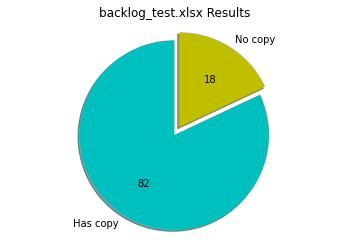

In [ ]:
#@title 4. Preview results

import matplotlib.pyplot as plt

labels = 'Has copy', 'No copy'
sizes = [hascopy, total-hascopy]
colors = ['c', 'y']
explode = (0.1, 0.0)

total = sum(sizes)

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct=lambda s: '{:.0f}'.format(s * total / 100), shadow=True, startangle=90)

plt.axis('equal') 
plt.title(input_name + ' Results')
plt.show()


In [ ]:
#@title 5. Export an output file to Excel

try:
    output_df.to_excel(output_name, index=False)
except:
    output_name = output_name.rsplit( ".", 1 )[0] + '.csv'
    output_df.to_csv(output_name, index=False)
print('Done!\U0001f44D')

Done!👍
